# 神経活動による不確実性の表現

ここまでは最尤推定やMAP推定などにより，パラメータの点推定を行ってきた．

Neural  variability

細胞内において確率分布を直接保持している可能性は低い．

**不確実性(uncertainty)** を神経回路で表現する方法として主に2つの符号化方法，**確率的集団符号化(probabilistic population coding; PPC)** および**サンプリングに基づく符号化(sampling-based coding; SBC or neural sampling model)** が提案されている．PPCは神経細胞集団により，確率分布を表現するというモデルである．SBCは神経活動が元の確率分布のサンプルを表現しており，時間的に多数の活動を集めることで元の分布の情報が得られるというモデルである．

```{note}
sampling-based codingの訳は良い訳が思いつかないので案があればコメントをいただきたく存じます．
```

(Walker et al., 2022)がまとめ．


(Fiser et al., 2010)の比較表を入れる．

In [1]:
using PyPlot, LinearAlgebra, Random, Distributions
using PyPlot: matplotlib
using KernelDensity
Random.seed!(2)
#rc("axes.spines", top=false, right=false)

TaskLocalRNG()

In [2]:
gaussian(x, μ, σ) = 1/(σ*sqrt(2*π))*exp(-0.5*((x-μ)/σ)^2)

gaussian (generic function with 1 method)

In [3]:
Ns = 10

10

In [4]:
μs = range(-2, 2, length=Ns)

-2.0:0.4444444444444444:2.0

In [5]:
μ_dist = -0.5

-0.5

In [6]:
x = -4:0.01:4
tuning_curves = hcat([gaussian.(x, μ, 0.5) for μ in μs]...)';

In [7]:
size(tuning_curves)

(10, 801)

In [8]:
mixed_gauss = Normal(μ_dist, 0.5)

Normal{Float64}(μ=-0.5, σ=0.5)

In [9]:
y = pdf.(mixed_gauss, x);

In [10]:
samples = rand(mixed_gauss, Ns);

In [11]:
U = kde(samples);

ポアソン分布

$$
P(X=k)={\frac  {e^{-\lambda} \lambda^k}{k!}}
$$

より，

$$
p(y \mid \mathbf{x}) \propto \prod_{i} \frac{e^{-f_{i}(y)} f_{i}(y)^{x_{i}}}{x_{i} !} p(y)
$$

In [12]:
d = Normal(0, 1)

Normal{Float64}(μ=0.0, σ=1.0)

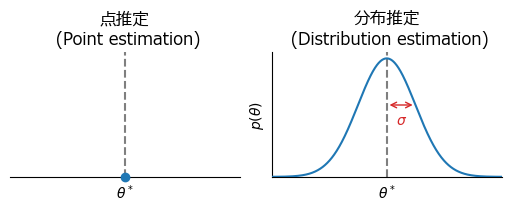

In [13]:
rc("font", family="Meiryo")
fig, ax = subplots(1,2, figsize=(5,2),sharex="all",sharey="all",constrained_layout=true)
ax[1].set_title("点推定\n (Point estimation)")
ax[2].set_title("分布推定\n (Distribution estimation)")
ax[2].set_ylabel(L"$p(\theta)$")
ax[1].scatter(0, 0,clip_on=false,zorder=5)
ax[2].plot(x, pdf.(d, x), zorder=5)
ax[1].spines.left.set_visible(false)
for i in 1:2
    ax[i].set_xlabel(L"$\theta^*$")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylim(0, )
    ax[i].set_xlim(-4,4)
    ax[i].axvline(0, linestyle="dashed", color="tab:gray")
    ax[i].spines.right.set_visible(false)
    ax[i].spines.top.set_visible(false)
end

ax[2].annotate(text="", xy=(0,pdf(d, 1)), xytext=(1,pdf(d, 1)), arrowprops=Dict("arrowstyle" => "<->", "color" => "tab:red"))
ax[2].text(0.5, pdf(d, 1)-0.05, L"$\sigma$",ha="center",va="center",color="tab:red");

In [14]:
ppc_fr = exp.(-(μs .- μ_dist).^2/0.5);

In [15]:
act = ppc_fr' * tuning_curves;

In [16]:
cm = get_cmap(:turbo) # get color map

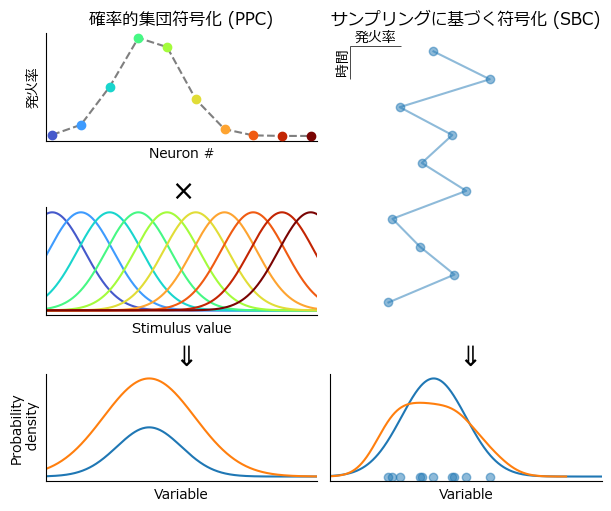

In [17]:
mosaic = """
AD
BD
CE
"""

fig, ax = plt.subplot_mosaic(mosaic,figsize=(6, 5),constrained_layout=true)
ax["A"].set_title("確率的集団符号化 (PPC)")

for i in 1:length(μs)
    ax["A"].scatter(μs[i], ppc_fr[i],color=cm(i/length(μs)),zorder=5)
end
ax["A"].plot(μs, ppc_fr, "--", color="tab:gray")
ax["A"].set_ylabel("発火率"); 
ax["A"].set_xlabel("Neuron #")
for i in 1:length(μs)
    ax["B"].plot(x, tuning_curves[i, :],color=cm(i/length(μs)))
end

ax["B"].set_title(L"$\times$", fontsize=20)
ax["B"].set_xlabel("Stimulus value")

ax["C"].set_title(L"$\Downarrow$", fontsize=20)
ax["C"].plot(x, y)
ax["C"].plot(x, act)
ax["C"].set_ylabel("Probability\n density"); 
ax["C"].set_xlabel("Variable")
for i in 'A':'C'
    ax[string(i)].spines.right.set_visible(false)
    ax[string(i)].spines.top.set_visible(false)
end


ax["D"].set_title("サンプリングに基づく符号化 (SBC)")
ax["D"].plot(samples, 1:Ns, "o-", alpha=0.5)
ax["D"].invert_yaxis()
ax["D"].text(-1.4, 0.5, "発火率", ha="center",va="center"); 
ax["D"].text(-1.9, 1.375, "時間", ha="center",va="center",rotation="vertical")
ax["D"].hlines(y=0.8, xmin=-1.8, xmax=-1.0, clip_on=false, color="k", linewidths=0.5)
ax["D"].vlines(x=-1.8, ymin=0.8, ymax=2.0, clip_on=false, color="k", linewidths=0.5)
ax["D"].xaxis.tick_top()
ax["D"].xaxis.set_label_position("top") 
ax["D"].axis("off")

ax["E"].set_title(L"$\Downarrow$", fontsize=20)
ax["E"].plot(x, y)
ax["E"].plot(U.x, U.density)
ax["E"].scatter(samples, zeros(Ns), alpha=0.5, marker="o")
ax["E"].spines.right.set_visible(false)
ax["E"].spines.top.set_visible(false)
ax["E"].set_xlabel("Variable")

for i in 'A':'E'
    ax[string(i)].set_xlim(-2.1, 2.1)
    ax[string(i)].set_xticks([])
    ax[string(i)].set_yticks([])
end

#fig.tight_layout()